In [1]:
# https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/wgan_gp/wgan_gp.py
# https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv
import argparse, os, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.autograd as autograd
import torch

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
# parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
# parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
# parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
# parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
# parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
# parser.add_argument("--channels", type=int, default=1, help="number of image channels")
# parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
# parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
# parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
# opt = parser.parse_args()
# print(opt)

class Args:
    def __init__(self,**D):
        for arg in D.keys(): 
            setattr(self,arg,D[arg])
            
opt = Args(b1=0.5, b2=0.999, batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_critic=5, n_epochs=200, sample_interval=5)
# b1,b2 adam args # clip_value not used # n_cpu not used # n_critic: train discriminator steps per genrator step # sample_interval=save result per ep
os.makedirs("images", exist_ok=True)
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False
print(opt.batch_size, img_shape, cuda)

64 (1, 28, 28) True


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

42000


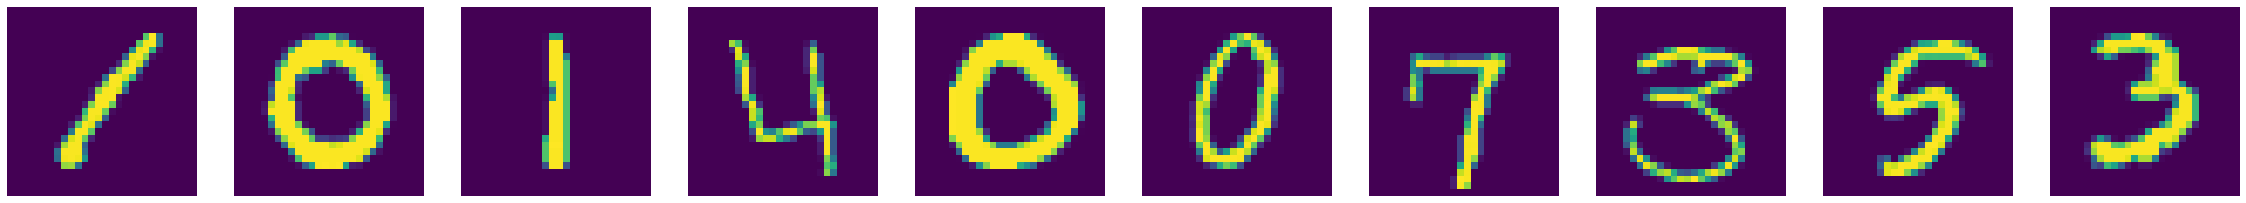

In [4]:
class MnistDataset(Dataset):
    def __init__(self, csvPath):
        self.df = pd.read_csv(csvPath)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        img = self.df.loc[index][1:].to_numpy().reshape(1,28,28) / 255.
        return img
    def showExamples(self):
        plt.figure(figsize=(4*10,4))
        for i in range(10):
            img = self.__getitem__(i).squeeze(0)
            plt.subplot(1,10,i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()
        
dataset = MnistDataset("./train.csv")
print(len(dataset))
dataset.showExamples()

In [5]:
lambda_gp = 10 # Loss weight for gradient penalty
generator = Generator()
discriminator = Discriminator()
print( generator ) # B,100 -> B,784
print( discriminator ) # B,784 -> 1
if cuda:
    generator.cuda()
    discriminator.cuda()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size, shuffle=True) # numpy -> torch.float32
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)

In [6]:
for epoch in range(opt.n_epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor)) # torch.float32 -> torch.float32 with auto-computing gradient # B,1,28,28 
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],opt.latent_dim)))) # generate noise # mean, std, output shape (B,100)
        fake_imgs = generator(z) # B,1,28,28

        real_validity = discriminator(real_imgs) # B,1 float
        fake_validity = discriminator(fake_imgs) # B,1 float

        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty # discriminator loss # discriminator output a score of "is_real"
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        if i % opt.n_critic == 0: # Train the generator every n_critic steps
            # -----------------
            #  Train Generator
            # -----------------
            fake_imgs = generator(z)

            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)
            g_loss.backward()
            optimizer_G.step()

            print( "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()), end="")

    if epoch % opt.sample_interval == 0:
        save_image(fake_imgs.data[:25], "images/%d.png" % epoch, nrow=5, normalize=True)
        generatorD = {'model_state_dict':generator.state_dict(),'epoch':epoch,'loss':g_loss}
        discriminatorD = {'model_state_dict':discriminator.state_dict(),'epoch':epoch,'loss':d_loss}
        torch.save({"generator":generatorD, "discriminator":discriminatorD}, f"ckpt-{epoch}.pth")
    print()

[Epoch 0/200] [Batch 655/657] [D loss: -3.351624] [G loss: 0.324616]]
[Epoch 1/200] [Batch 655/657] [D loss: -2.675830] [G loss: 0.739876]]
[Epoch 2/200] [Batch 655/657] [D loss: -2.428325] [G loss: 0.343201]]
[Epoch 3/200] [Batch 655/657] [D loss: -2.410306] [G loss: 0.270381]]
[Epoch 4/200] [Batch 655/657] [D loss: -2.383744] [G loss: 0.432265]]
[Epoch 5/200] [Batch 655/657] [D loss: -2.276072] [G loss: 0.770734]]
[Epoch 6/200] [Batch 655/657] [D loss: -2.087310] [G loss: 0.479482]]
[Epoch 7/200] [Batch 655/657] [D loss: -1.998771] [G loss: 0.431953]]
[Epoch 8/200] [Batch 655/657] [D loss: -2.022096] [G loss: 0.687594]]
[Epoch 9/200] [Batch 655/657] [D loss: -2.070657] [G loss: 1.641589]
[Epoch 10/200] [Batch 655/657] [D loss: -1.915402] [G loss: 0.891725]
[Epoch 11/200] [Batch 655/657] [D loss: -1.845676] [G loss: 0.874416]
[Epoch 12/200] [Batch 655/657] [D loss: -1.978239] [G loss: 1.912584]
[Epoch 13/200] [Batch 655/657] [D loss: -1.800895] [G loss: 1.385771]
[Epoch 14/200] [Batch

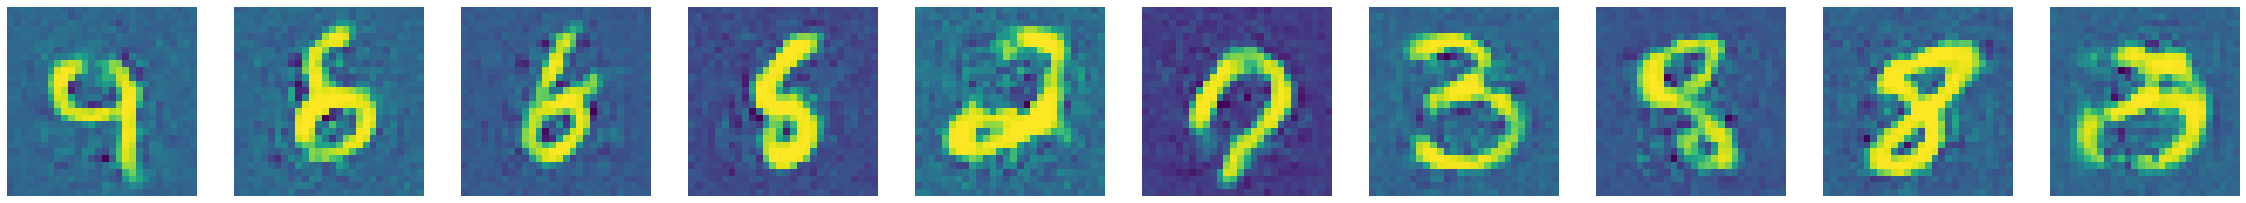

In [29]:
with torch.no_grad():
    z = torch.Tensor(np.random.normal(0,1,(16,100))).to('cuda')
    fakeImgs = generator( z )
    fakeImgs = fakeImgs.cpu().numpy()
    
    plt.figure(figsize=(4*10,4))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow( fakeImgs[i].reshape(28,28) )
        plt.axis('off')
    plt.show()

In [36]:
D = torch.load("./ckpt-195.pth")
ckpt = D['generator']['model_state_dict']

newGen = Generator().to('cuda')
newGen.load_state_dict(ckpt)

<All keys matched successfully>

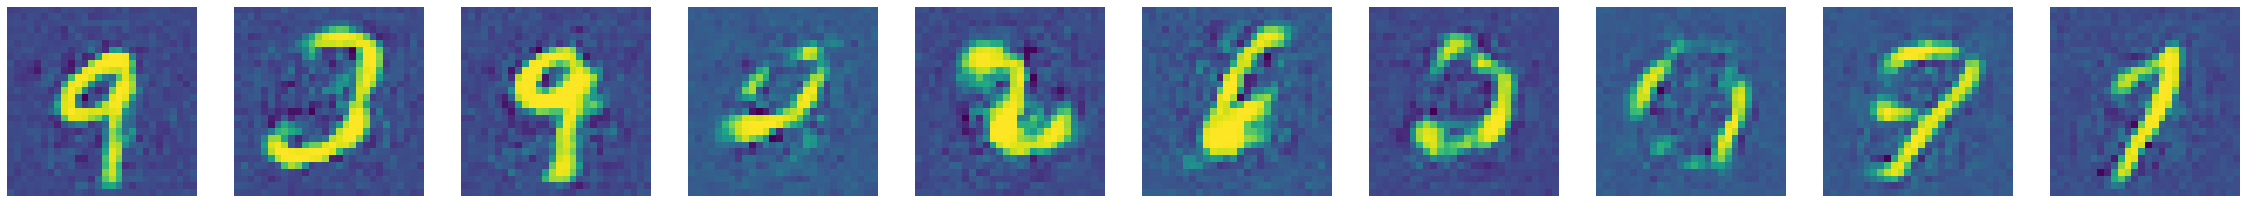

In [37]:
with torch.no_grad():
    z = torch.Tensor(np.random.normal(0,1,(16,100))).to('cuda')
    fakeImgs = newGen( z )
    fakeImgs = fakeImgs.cpu().numpy()
    
    plt.figure(figsize=(4*10,4))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow( fakeImgs[i].reshape(28,28) )
        plt.axis('off')
    plt.show()